## Training dense head vs training entire network?

This notebook aims to answer whether it makes more sense to:
1) train just the dense head of the network & treat the pre-trained convolutional base (VGG16) as a feature selector 
2) train the entire net

Results imply that it's better to go with 1), although I'm not confident enough in the choice of CT scan windowing & my training pipeline to trat it as a definite answer.

In [32]:
DATA_DIR = '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'
!ls $DATA_DIR'stage_2_test' | wc

 121232  121232 2060944


In [33]:
import os
DATA_DIR = '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'
!ls $DATA_DIR
INPUT_SHAPE = (512, 512, 3)

stage_2_sample_submission.csv  stage_2_test  stage_2_train  stage_2_train.csv


In [34]:
import pandas as pd

def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img


def read_trainset(filename=DATA_DIR+"stage_2_train.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    duplicates_to_remove = [
        56346,56347,56348,56349,
        56350,56351,1171830,1171831,
        1171832,1171833,1171834,1171835,
        3705312,3705313,3705314,3705315,
        3705316,3705317,3842478,3842479,
        3842480,3842481,3842482,3842483
    ]
    
    df = df.drop(index=duplicates_to_remove)
    df = df.reset_index(drop=True)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

In [35]:
import keras
import cv2
from math import ceil
import numpy as np
import pydicom

np.random.seed(257)

def _read(path, desired_size):
    """Will be used in DataGenerator"""
    
    dcm = pydicom.dcmread(path)
    img = bsb_window(dcm)
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
    
    return img

class DataGenerator(keras.utils.Sequence):

    def __init__(self, img_dir, id_list, labels, batch_size, img_size):

        self.list_IDs = id_list
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()

    def __len__(self):
        return int(ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indices]
        
        if self.labels is not None:
            X, Y = self.__data_generation(list_IDs_temp)
            return X, Y
        else:
            X = self.__data_generation(list_IDs_temp)
            return X
        
    def on_epoch_end(self):
        
        
        if self.labels is not None: # for training phase we undersample and shuffle
            # keep probability of any=0 and any=1
            keep_prob = self.labels.iloc[:, 0].map({0: 0.35, 1: 0.5})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = np.arange(len(self.list_IDs))[keep]
            np.random.shuffle(self.indices)
        else:
            self.indices = np.arange(len(self.list_IDs))
            
    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.img_size))
        
        if self.labels is not None: # training phase
            Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
                Y[i,] = self.labels.loc[ID].values
        
            return X, Y
        
        else: # test phase
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
            
            return X

In [36]:
from sklearn.model_selection import ShuffleSplit 

train_df = read_trainset()

# k-fold splitting
ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=257).split(train_df.index)
# get indeces for one split
train_idx, valid_idx = next(ss)
train_df_kfold = train_df.iloc[train_idx]
valid_df_kfold = train_df.iloc[valid_idx]

In [37]:
gen = DataGenerator(img_dir=DATA_DIR+'stage_2_train/',
                    id_list=train_df_kfold.index[:10000], #MAGIC, #BUG
                    labels=train_df_kfold[:10000], #MAGIC, #BUG
                    batch_size=4,
                    img_size=INPUT_SHAPE)

In [38]:
from keras import backend as K

def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    ---------------------------------------------------
    """
    
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)

In [39]:
import keras
from keras.applications.vgg16 import VGG16
from keras import layers
import numpy as np

conv_base = VGG16(weights='imagenet', input_shape=INPUT_SHAPE ,include_top=False)

conv_base.trainable = False
model = keras.models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    #loss='categorical_crossentropy', # mutually exclusive
    optimizer=keras.optimizers.Adam(lr=1e-3),
    metrics=['accuracy']
    
)
model.summary()


#conv_base = VGG16(weights='imagenet', input_shape=INPUT_SHAPE ,include_top=False)
#conv_base = VGG16(weights=None, input_shape=INPUT_SHAPE ,include_top=False) #random weight ``init

conv_base.trainable = True
model2 = keras.models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(6, activation='sigmoid'))

model2.compile(
    loss='binary_crossentropy',
    #loss='categorical_crossentropy', # mutually exclusive
    optimizer=keras.optimizers.Adam(lr=1e-3),
    metrics=['accuracy']
    
)
model2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               33554688  
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 1542      
Total params: 48,270,918
Trainable params: 33,556,230
Non-trainable params: 14,714,688
_________________________________________________________________
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 16, 16, 512)       14714688  
___________

In [40]:
hist = model.fit_generator(gen,
                    epochs=15,
                    verbose=True,
                    use_multiprocessing=False,
                    workers=4)

Epoch 1/15
931/931 [==============================] - 81s 87ms/step - loss: 0.7721 - accuracy: 0.9013
Epoch 2/15
921/921 [==============================] - 81s 88ms/step - loss: 0.2107 - accuracy: 0.9221
Epoch 3/15
940/940 [==============================] - 82s 87ms/step - loss: 0.2023 - accuracy: 0.9225
Epoch 4/15
929/929 [==============================] - 83s 89ms/step - loss: 0.1864 - accuracy: 0.9277
Epoch 5/15
963/963 [==============================] - 85s 89ms/step - loss: 0.1889 - accuracy: 0.9276
Epoch 6/15
927/927 [==============================] - 81s 87ms/step - loss: 0.1849 - accuracy: 0.9264
Epoch 7/15
930/930 [==============================] - 81s 87ms/step - loss: 0.1746 - accuracy: 0.9307
Epoch 8/15
932/932 [==============================] - 81s 87ms/step - loss: 0.1771 - accuracy: 0.9296
Epoch 9/15
911/911 [==============================] - 80s 88ms/step - loss: 0.1599 - accuracy: 0.9344
Epoch 10/15
941/941 [==============================] - 81s 86ms/step - loss: 0.154

In [41]:
hist2 = model2.fit_generator(gen,
                    epochs=15,
                    verbose=True,
                    use_multiprocessing=False,
                    workers=4)

Epoch 1/15
931/931 [==============================] - 183s 197ms/step - loss: 4.2869 - accuracy: 0.9200
Epoch 2/15
917/917 [==============================] - 180s 196ms/step - loss: 0.2546 - accuracy: 0.9207
Epoch 3/15
940/940 [==============================] - 184s 196ms/step - loss: 0.2492 - accuracy: 0.9230
Epoch 4/15
921/921 [==============================] - 184s 199ms/step - loss: 0.2608 - accuracy: 0.9179
Epoch 5/15
919/919 [==============================] - 181s 197ms/step - loss: 0.2570 - accuracy: 0.9198
Epoch 6/15
932/932 [==============================] - 183s 196ms/step - loss: 0.2517 - accuracy: 0.9225
Epoch 7/15
944/944 [==============================] - 185s 196ms/step - loss: 0.2515 - accuracy: 0.9227
Epoch 8/15
925/925 [==============================] - 181s 196ms/step - loss: 0.2614 - accuracy: 0.9177
Epoch 9/15
935/935 [==============================] - 184s 196ms/step - loss: 0.2565 - accuracy: 0.9201
Epoch 10/15
928/928 [==============================] - 182s 196m

In [44]:
X,y = gen[0]

In [45]:
p = model.predict(X)

In [46]:
p.shape

(4, 6)

In [48]:
p > 0.5

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False]])

In [ ]:
model.predict(X) > 0.5

In [ ]:
y

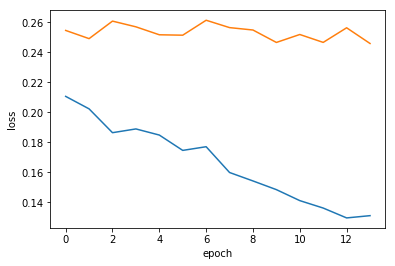

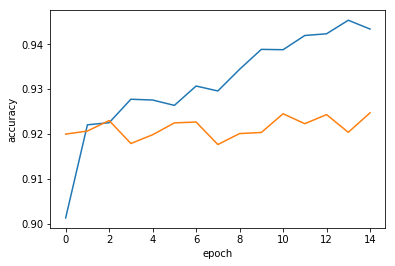

In [53]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'][1:])
plt.plot(hist2.history['loss'][1:])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(hist.history['accuracy'])
plt.plot(hist2.history['accuracy'])
plt.show()